[Changes since first put online:

I have removed `plt.show()` from the command that used to be `display_phases`.  To display things, you will now need to include that command, and I've renamed the command `plot_phases`]

# Kuramoto oscillation

The observation that oscillating things often end up curiously coupled dates back to when Huygens invented pendulum clocks in 1656.  He noted that if there were two clocks that were attached to the same piece of wood, the pendulums would tend to either be in phase or exactly out of phase.  [Here is a great example](https://www.youtube.com/watch?v=5v5eBf2KwF8).  You don't even have to watch it, just listen to it.  This sort of behavior has been seen in many other systems since then.  Often (as in the video) all of the oscillators interact.  but in some cases they only interact with physically nearby neighbors, or otherwise on a network.

In the Kuramoto model, we assume that each node $j$ of a network has an associated periodic process happening.  We will refer to the "node" as an "oscillator".  Additionally we assume that each oscillator's state can be described entirely by a phase $\phi_j$ where $0 \leq \phi_j < 2\pi$.

We assume that 
- each oscillator has a natural frequency $\omega_j$ so that $d\phi_j/dt = \omega_j$ in the absence of input from its neighbors.
- the oscillators are coupled so that each neighbor of an oscillator influences the rate that its phase changes, and we assume that this interaction contributes $c \sin[\phi_k(t) - \phi_j(t)]$ to the rate of change of $\phi_j$.  So if $\phi_k>\phi_j$, $\phi_j$ increases faster in an attempt to "catch up", and *vice versa*.
- if the network is directed, only the predecessors $k$ of an oscillator $j$ (i.e., those nodes for which $(k,j)$ is a directed edge) affect $d\phi_j/dt$.

The resulting system of equations is
\begin{equation*}
\frac{d\phi_j}{dt} =  \omega_j + c\sum_{k:\{k,j\}\text{ is an edge}} \sin[\phi_k(t) - \phi_j(t)]
\end{equation*}
where the summation is either over neighbors (in the undirected case) or predecessors (in the directed case).

## Code for simulating Kuramoto oscillators on a network

I'm going to provide some code for you to use to simulate Kuramoto oscillators.

You will need to use networkx commands to generate whatever random graphs you want.

Then you can use this code to simulate the oscillators and display their phases.  Start with smaller networks since solving the differential equations may be a slow process.



In [22]:
import networkx as nx
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

#First some things that will be needed to find the derivatives.

def phase_deriv(node, X, G, frequencies, c):
    #calculates the derivative of the phase of `node` given the current state
    
    if nx.is_directed(G):  #behaves differently if graph is directed
        phase_differences = [(X[pred] - X[node]) for pred in G.predecessors(node)]
    else:
        phase_differences = [(X[neighbor] - X[node]) for neighbor in G.neighbors(node)]
    sin_phase_diff = np.sin(np.array(phase_differences))
    #sin_phase_diff = map(lambda x: scipy.sin(2*scipy.pi*x), phase_differences)
    Y = sin_phase_diff.sum()
    return frequencies[node] + c*Y


def dphase_dt(X, t, G, frequencies, c):  
    #uses phase_deriv to find the derivative of phases of all nodes.
    dXdt = np.array([phase_deriv(node, X, G, frequencies, c) for node in G.nodes()])
    return dXdt


def solve_model(G, tstop, c = 1, initial_phase = None, natural_frequencies = None, ntimes = 1001):
    r'''
    The arguments of this function are:
    
    G  - a networkx Graph or a DiGraph
    
    tstop   - final time of simulation (assumes that it starts at 0)
    
    c   - an optional argument for the coupling strength, it defaults to 1.
    
    initial_phase - an optional argument giving the initial_phase of all nodes.  
                    Input as a dict.  It defaults to random values in (0, 2pi) for each node
                    
    natural_frequencies - an optional argument giving the natural frequencies of all nodes.
                    Input as a dict.  It defaults to random values in -0.5, 0.5
    
    ntimes - an integer stating how many points between 0 and tstop should be returned.
                    
                    
                    
    the function returns:
    times - an np array of times
    X  - a 2d np array giving the oscillator phase of each node at each time in times.'''
    
    nodelist = list(G.nodes())
    if natural_frequencies is None:
        frequencies =[-0.5+np.random.random() for node in nodelist] 
    else:
        frequencies = [natural_frequencies[node] for node in nodelist]
    if initial_phase is None:
        phase0 = np.array([np.random.random()*2*np.pi for node in nodelist])
    else:
        phase0 = np.array([initial_phase[node] for node in nodelist])
    times = np.linspace(0, tstop, ntimes)
    X = integrate.odeint(dphase_dt, phase0, times, args = (G, frequencies, c))
    
    return times, X
        
def plot_phases(times, X, start_time = None, stop_time = None):
    r''' 
    
    Code for displaying the phases of the oscillators.  
    
    Arguments
    ---------
    
    times - the times returned by solve_model
    X - the phases returned by solve_model
    
    optional Arguments
    ------------------
    start_time   - the time to start the plots at.    default to initial time
    stop_time    - the time to stop the plots at.    default to final time'''
    
    if start_time is None:
        start_index =0
    elif start_time>times[-1]:
        raise ValueError("start_time is greater than times[-1]")
    else:
        start_index = np.argmax(times>=start_time)
    if stop_time is None:
        stop_index = len(times)-1
    elif stop_time < times[0]:
        raise ValueError("stop_time is less than times[0]")
    else:
        stop_index = np.argmax(times>= stop_time)
    if start_index>stop_index:
        raise ValueError("start_time > stop_time")
        
    plt.clf()
    for node in G.nodes():
        x = times[start_index:stop_index]
        y = X[start_index:stop_index, node]%(2*np.pi)
        
        #when we mod out by 2pi, we introduce discontinuities (where it crosses the top a
        #re-enters on the bottom).  These next commands prevent matplotlib from putting vertical
        #lines at those points.
        jumppos = np.where(np.abs(np.diff(y)) >= 1.5*np.pi)[0]+1
        x = np.insert(x, jumppos, np.nan)
        y = np.insert(y, jumppos, np.nan)
        plt.plot(x,y)
    plt.xlabel('times')
    plt.ylabel('phases')


The code is assuming that nodes in `G` are named $0, 1, \ldots, N-1$.  To make sure this is what they are named in your graph, I recommend doing  
`G = nx.convert_node_labels_to_integers(G)`  
just to be sure before calling these functions.

Many of the networkx random graph functions will already have those names, but not all.



### Example

In the example below I build a DIRECTED erdos-renyi network.

Then I run the same thing on an undirected erdos-renyi network.


In [23]:
G = nx.fast_gnp_random_graph(100, 0.03, directed=True)
G = nx.convert_node_labels_to_integers(G)  #
times, X = solve_model(G, 1000, c = 2, ntimes = 10001) #running to time 1000


ValueError: start_time is greater than times[-1]

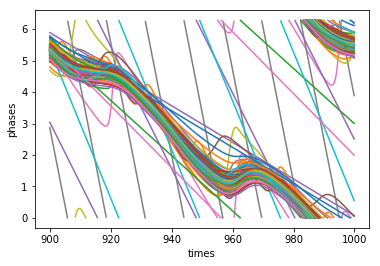

In [25]:
plot_phases(times, X, start_time = 900, stop_time = 1000)
plt.show()

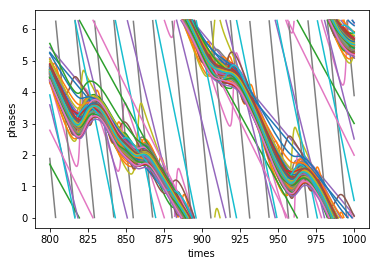

In [26]:
plot_phases(times, X, start_time = 800, stop_time = 1000)
plt.show()

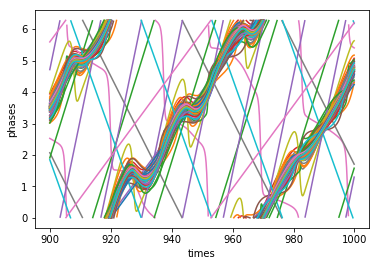

In [27]:
G1 = nx.fast_gnp_random_graph(100, 0.03)
G1 = nx.convert_node_labels_to_integers(G1)  #
times1, X1 = solve_model(G, 1000, c = 4, ntimes = 10001) #running to time 1000
plot_phases(times1, X1, start_time = 900, stop_time = 1000)
plt.show()

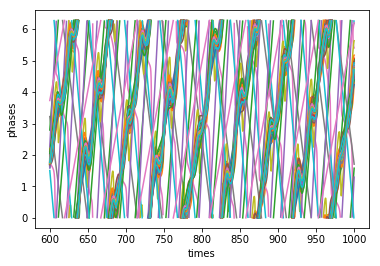

In [28]:
plot_phases(times1, X1, start_time = 600, stop_time = 1000)
plt.show()

Please try your own examples, playing with coupling strength `c`, and different graph types.  You may want to use a smaller final time in `solve_model` (I used 1000).

## Basic Analysis of the Kuramoto model

Now we're going to try to get a more in depth understanding of the Kuramoto model.

It turns out that it's actually very hard to prove things about this model.  So we're going to start by simplifying it a lot.

We'll start by looking at a small population, but assume that all individuals are in contact with one another.  In network theory, this means we are going to use the "complete graph".

There are faster ways to write our code for the complete graph, but we'll stick to what we've already got.

We'll be interested in understanding what happens as the number of nodes goes to infinity.  We'll want the total impact of other oscillators on an indivdiual to not become unbounded.  So we'll define a `global_clustering` and set `c = global_coupling/N`.


Then we have
\begin{equation*}
\frac{d\phi_j}{dt} =  \omega_j + \text{global_coupling} \frac{1}{N} \sum_{k} \sin\left[\phi_k(t) - \phi_j(t)\right]
\end{equation*}


In [29]:
G = nx.complete_graph(20)
G = nx.convert_node_labels_to_integers(G)  #not needed


0.0


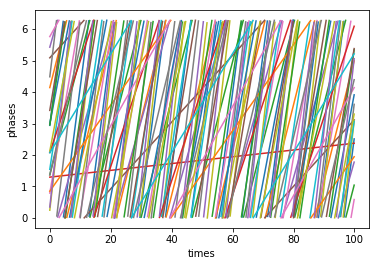

0.1


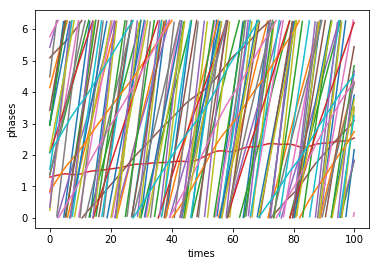

0.2


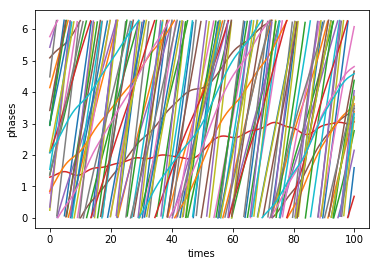

0.30000000000000004


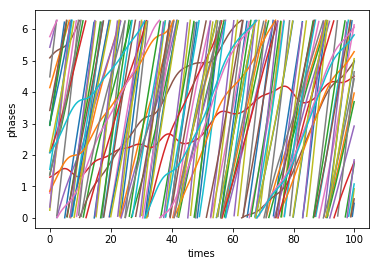

0.4


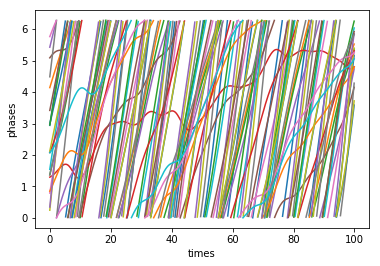

0.5


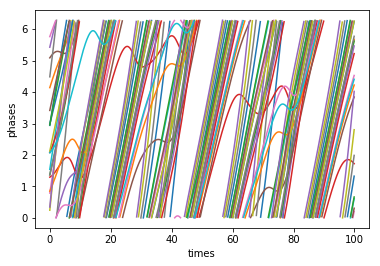

0.6000000000000001


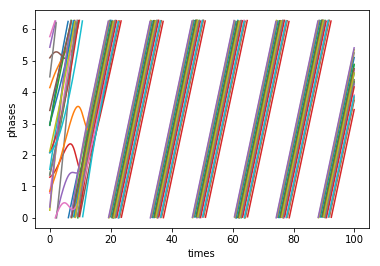

0.7000000000000001


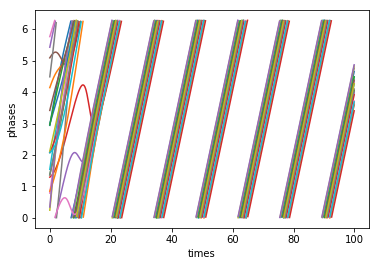

0.8


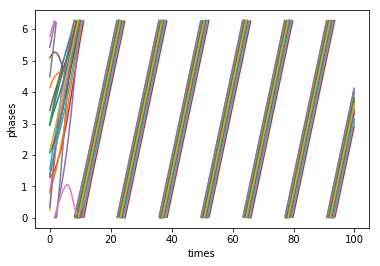

0.9


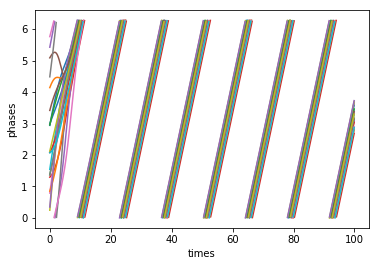

1.0


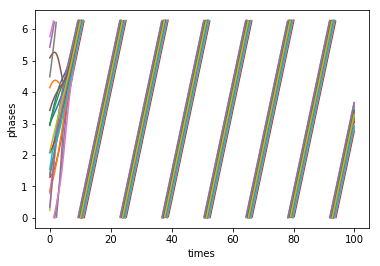

1.1


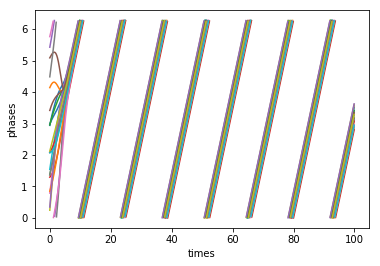

1.2000000000000002


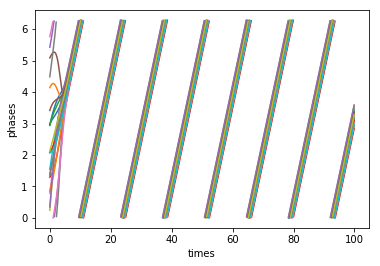

1.3


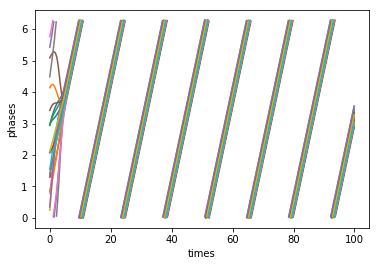

1.4000000000000001


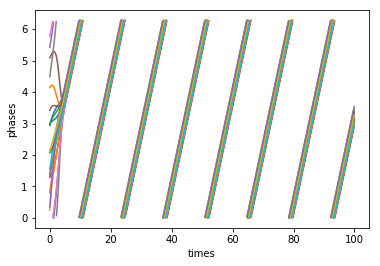

1.5


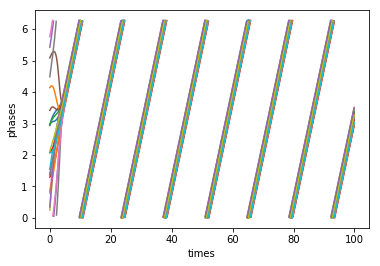

1.6


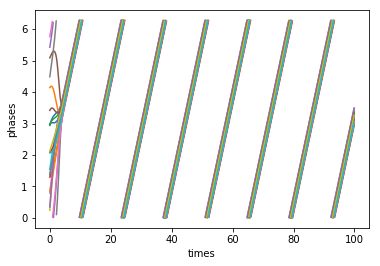

1.7000000000000002


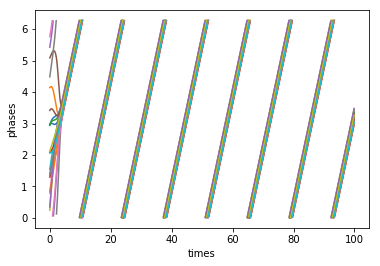

1.8


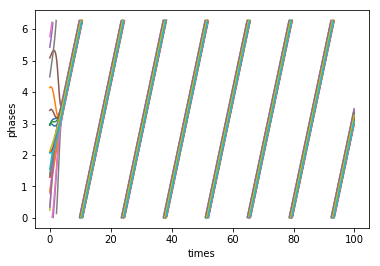

1.9000000000000001


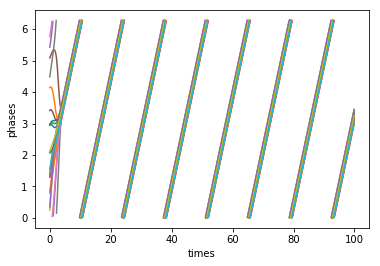

2.0


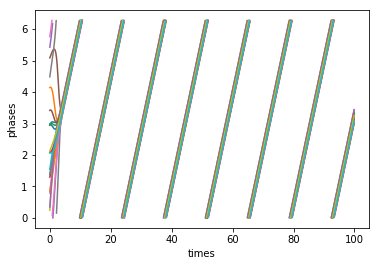

In [30]:
nodelist = list(G.nodes())
N = len(nodelist)
natural_frequencies ={node:np.random.random() for node in nodelist} 
initial_phase = {node: np.random.random()*2*np.pi for node in nodelist}

for global_coupling in np.linspace(0,2,21):
    print(global_coupling)
    times, X = solve_model(G, 100, c = global_coupling/N, ntimes = 1001,
                           natural_frequencies= natural_frequencies, 
                           initial_phase = initial_phase)
    
    plot_phases(times, X)
    plt.show()

We'll move to a frame of reference so that everything grows with velocity equal to the average of $\omega$.  So then the $\omega_j$ will have an average of $0$.  This is a fairly common trick and it works as follows:
We define $\omega_j = \hat{\omega}_j + \langle \omega \rangle$ where the angled brackets denotes the population averge value, and then we similarly set $\phi_j = \hat{\phi}_j + \langle \omega \rangle t$. 

\begin{align*}
\frac{d\hat{\phi}_j}{dt} + \langle \omega \rangle &= \hat{\omega}_j + \langle \omega \rangle 
+ \text{global_coupling} \frac{1}{N} \sum_{k} \sin\left[\hat{\phi}_k(t) +\langle \omega \rangle - \hat{\phi}_j(t)-\langle \omega\rangle \right]\\
\frac{d\hat{\phi}_j}{dt} &= \hat{\omega}_j + \text{global_coupling} \frac{1}{N} \sum_{k} \sin\left[\hat{\phi}_k(t) - \hat{\phi}_j(t)\right]
\end{align*}
We can drop the hats and we get back our original equation, but now the $\omega_j$ terms have average zero.
\begin{equation*}
\frac{d\phi_j}{dt} = \omega_j + \text{global_coupling} \frac{1}{N} \sum_{k} \sin\left[\phi_k(t) - \phi_j(t)\right]
\end{equation*}
There's still one more variable change I'm going to do later.  But we'll postpone that until it makes sense.

In the below we'll subtract off the *expected* mean so that it won't grow quickly.



0.0


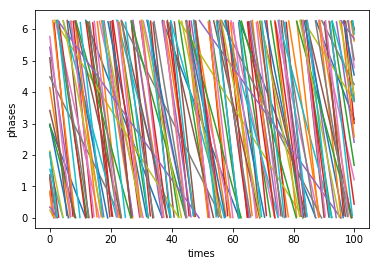

0.1


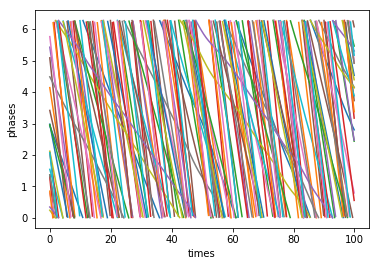

0.2


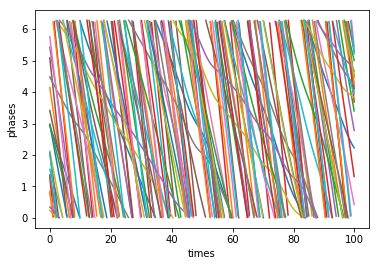

0.30000000000000004


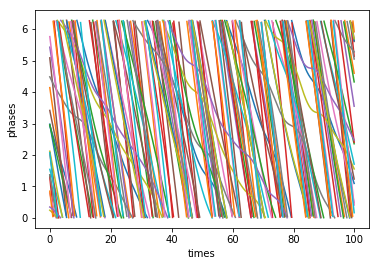

0.4


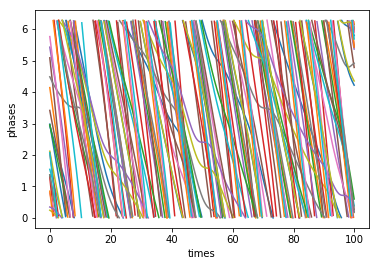

0.5


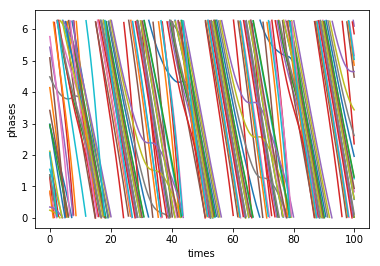

0.6000000000000001


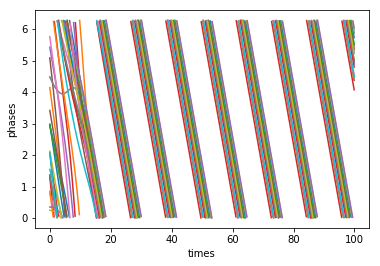

0.7000000000000001


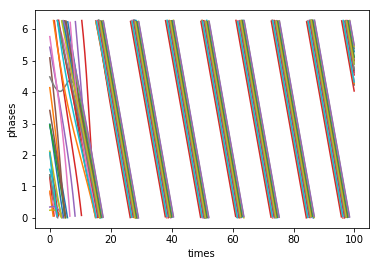

0.8


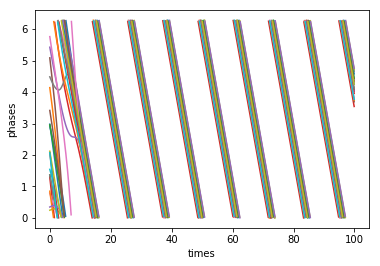

0.9


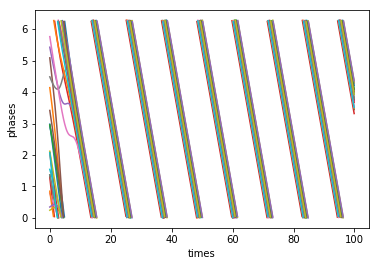

1.0


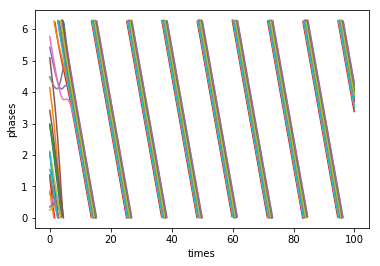

In [32]:

natural_frequencies ={node:natural_frequencies[node]-0.5 for node in nodelist} 

for global_coupling in np.linspace(0,1,11):
    print(global_coupling)
    times, X = solve_model(G, 100, c = global_coupling/N, ntimes = 1001,
                           natural_frequencies= natural_frequencies, 
                           initial_phase = initial_phase)
    
    plot_phases(times, X)
    plt.show()

When they sync they move much slower than they used to (without the phase adjustment).  But it's still moving.  This is because the average of our $20$ phases was expected to be $0$, but turned out to be a little off.  

What happens for larger values of $N$?  We should get slower movement.  Let's try $N=50$, with the expected mean subtracted off:

0.0


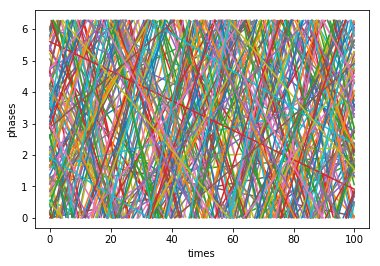

0.1


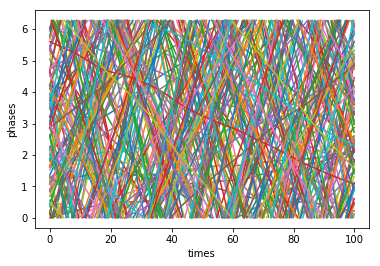

0.2


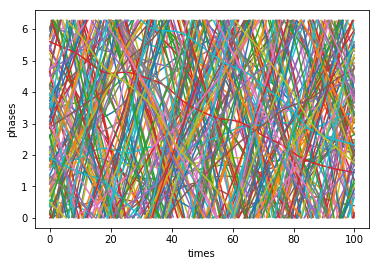

0.30000000000000004


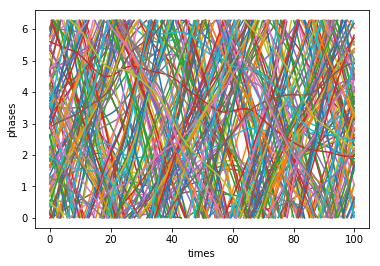

0.4


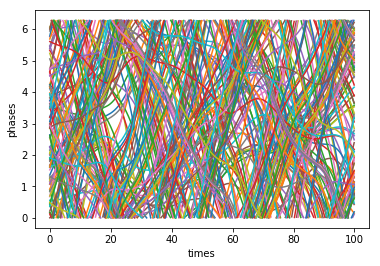

0.5


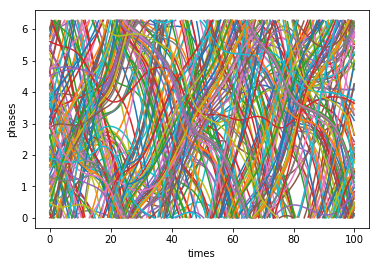

0.6000000000000001


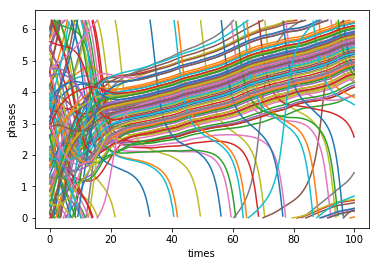

0.7000000000000001


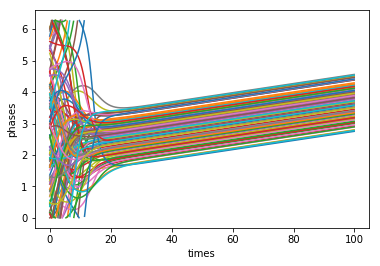

0.8


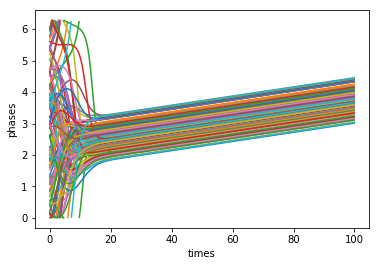

0.9


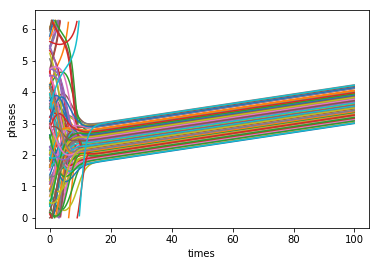

1.0


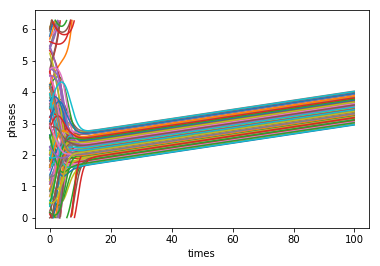

In [33]:
G = nx.complete_graph(100)
G = nx.convert_node_labels_to_integers(G)  #not needed

nodelist = list(G.nodes())
N = len(nodelist)
natural_frequencies ={node:np.random.random()-0.5 for node in nodelist} #expected mean = 0
initial_phase = {node: np.random.random()*2*np.pi for node in nodelist}

for global_coupling in np.linspace(0,1,11):
    print(global_coupling)
    times, X = solve_model(G, 100, c = global_coupling/N, ntimes = 1001,
                           natural_frequencies= natural_frequencies, 
                           initial_phase = initial_phase)
    
    plot_phases(times, X)
    plt.show()

The slope is now much closer to zero.  But also - notice that the slopes (i.e., net frequency) of all the straight bits in the different plots are the same, and also their locations are the same (their width does change however). 

Let's zoom in a bit closer to the transition location.

0.55


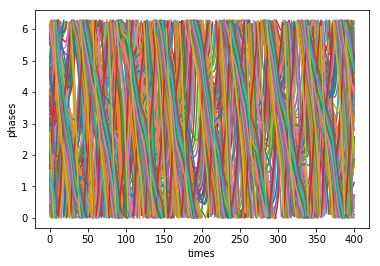

0.5700000000000001


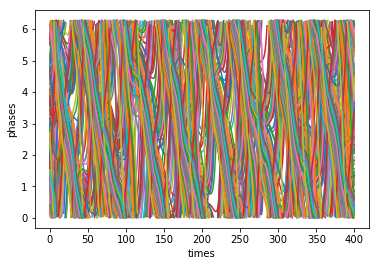

0.5900000000000001


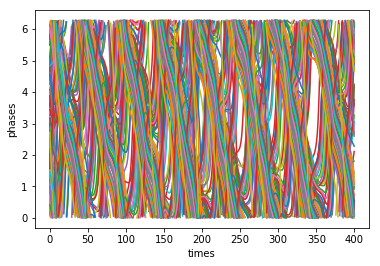

0.61


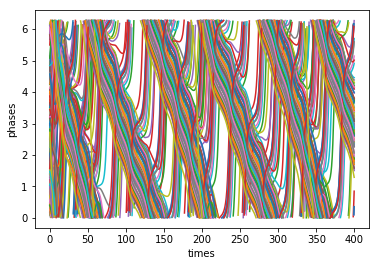

0.63


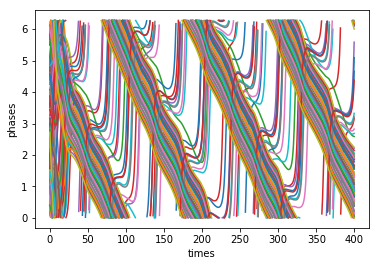

0.65


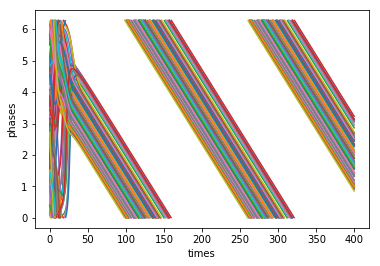

In [15]:
for global_coupling in np.linspace(0.55,0.65,6):
    print(global_coupling)
    times, X = solve_model(G, 400, c = global_coupling/N, ntimes = 1001,
                           natural_frequencies= natural_frequencies, 
                           initial_phase = initial_phase)
    
    plot_phases(times, X)
    plt.show()

What do you think is happening just below the coupling where we have **everything** locked in? Are some of them locked in and others not?  If so, can you say anything about the $\omega$ values which are locked in and which are not? 





Let's try to analyze what would happen for $N \to \infty$.  

Using some complex exponentials
\begin{align*}
\frac{d\phi_j}{dt} &=  \omega_j + \text{global_coupling} \frac{1}{N} \mathbb{Im} \left[\sum_{k} e^{i\phi_k(t) - i\phi_j(t)}\right]\\
&= \omega_j + \text{global_coupling} \cdot \mathbb{Im} \left[e^{-i\phi_j(t)}\frac{1}{N}\sum_{k} e^{i\phi_k(t)}\right]\\
\end{align*}
So we've got the average of a bunch of complex exponentials in there.  We're going to give that average a name, and write it in polar form.
\begin{equation*}
R(t) e^{i \Phi(t)} = \frac{1}{N}\sum_{k} e^{i\phi_k(t)}
\end{equation*}

Let's look back where there is synchronization.  We will make the hypothesis that the contribution to $R$ and $\Phi$ from the oscillators that don't synchronize with the others will cancel each other out (having a value of $-\omega$ is likely to be cancelled out by the contribution from a similar term with $+\omega$ and our distribution is symmetric).  Meanwhile the ones that synchronize all become constant.  So we expect $R$ and $\Phi$ to be constant (once we've moved into the moving frame).


Finally we do one last substitution by assuming that $\Phi(t)$ goes to a constant $\Phi(\infty)$ as $t\to\infty$.  Set $\theta_j = \phi_j - \Phi(\infty)$.  Then $\frac{d\theta_j}{dt} = \frac{d\phi_j}{dt}$, so the left hand side stays the same.  Similarly set $\Theta(t)  = \Phi(t)-\Phi(\infty)$.  Once it's synchronized, we expect $\Theta=0$. 


With this we finally have
\begin{equation*}
\frac{d\theta_j}{dt} = \omega_j + \text{global_coupling} \cdot R(t) \sin\left[ \Theta - \theta_j(t) \right]
\end{equation*}

Let's try to analyze the long-term behavior.  At large time we are predicting that $\Theta(t) \to 0$ and $R$ is constant.  So we have
\begin{align*}
\frac{d\theta_j}{dt} &= \omega_j + \text{global_coupling}\cdot R \sin (-\theta_j)\\
&= \omega_j - \text{global_coupling}\cdot R \sin (\theta_j)
\end{align*}

Can the oscillator sync?  Well it can sync if the left hand side goes to $0$.  Then we must have
\begin{equation*}
\omega_j =  \text{global_coupling}\cdot R   \sin(\theta_j)
\end{equation*}
There is a $\theta_j$ for which this is possible when 
\begin{equation*}
\left|\frac{\omega_j}{\text{global_coupling}\cdot R}\right| \leq 1
\end{equation*}

So, we predict that if $\omega_j > \text{global_coupling}\cdot R$, then this oscillator will not sync with the others.


### Finding $R$

So we've found expressions for $\theta_j$ given $R$.  Now we're going to try to find $R$ given all of the different $\theta_j$.  This is of course circular logic.  Even if we prove there are **consistent** solutions, this isn't a proof that the solutions are attracting (though our simulations strongly suggest they are).

Assuming that synchronization has occurred and accounting for all of the changes of variables, we have for large $t$
\begin{equation*}
R = \frac{1}{N} \sum_k e^{i \theta_k}
\end{equation*}
If an oscillator has synced (i.e., $\omega_k$ satisfied the inequality above) then $\sin(\theta_k) = \omega_k / R \cdot \text{global_coupling}$ and we can solve for $e^{i \theta_k}$.  If an oscillator won't sync, then we expect that it will (on average) cancel out with others that do not sync.

Taking the large $N$ limit, we replace this with an integral.  The imaginary parts cancel to yield the real number $R$ and we can treat $\theta$ as a function of $\omega$:
\begin{equation*}
R = \int_{-\text{global_coupling}\cdot R}^{\text{global_coupling}\cdot R} 
\cos(\theta(\omega))  p(\omega) \, d\omega
\end{equation*}
where $p(\omega)$ is given by our distribution of $\omega$.  The distribution on $\omega$ and our relation between $\omega$, $R$, the coupling, and $\theta$ allow us to convert this integral into an integral over $\theta$
\begin{equation*}
R = R\text{global_coupling} \int_{-\pi/2}^{\pi/2} \cos^2(\theta)p(R \text{global_coupling} \sin(\theta)) \, d \theta
\end{equation*}
We aren't going to try to do that integral.  But we're going to note that one solution is $R=0$ (which is what we see when syncing does not happen).  The other solution exists for large enough $\text{global_coupling}$.

So a self-consistent solution exists.  We have not proven that it is stable.  Normally that would be the next step.  However, I saw a lecture where Steven Strogatz said that there were unexpected challenges in proving stability.  I haven't seen the proof myself.  So I am not including stability here.

## Discussion

So now that we've done all of that analysis, let's see what we can understand of it.

The oscillators that do not sync interact with other oscillators, but on average in the large $N$ limit, they seem to cancel each other out.

When there is enough coupling for only a little synchronization, most oscillators may have large enough $\omega$ to avoid being trapped.  These unsynced oscillators make no net contribution.  However the synced oscillators do produce a small net effect.  This causes the "order parameter" $R$ to take a positive value.

We now see a positive feedback.  If we slightly increase the coupling, this means that for the given $R$ more oscillators can be trapped, which increases $R$, which increases the number of oscillators that can be trapped, which increases $R$ etc (each pass through the cycle is smaller then the previous and the summed effect converges).  

# Analysis of the Kuramoto model on graphs

So far we've done simulations on networks and seen lots of stuff.  Then we did some analysis of the all-to-all (mean field) model.  Now we're going to try to analyze behavior on graphs.

One of the things that helped us in the case where there was complete coupling was that the oscillators whose frequency was too large to be coupled would cancel with the others.  That's not longer the case in a graph.  If my neighbor is not locked in to the synchronization, then on each cycle my neighbor will pull and push me.  Unless my degree is very large, there won't be others to cancel out those effects.  So even though I might be locked in with the synchronized state, the periodic pushing/pulling by my neighbor will move me around relative to that state, and then I will push/pull other neighbors around.

Additionally, there will not be a simple threshold that determines whether a node does or does not get locked in to the synchronized state.  It will be influenced by how many synchronized neighbors a node has and how much those neighbors are being pushed/pulled by their neighbors.
This at least in part explains why the synchronized state we seem to see in the (low-degree) Erdos-Renyi graphs was much more dynamic than the state in the fully mixed graphs.

So it's clear that analysis of the dynamics on a graph can be significantly more complex.  We can still have syncing, but it is harder to get there.

## Kuramoto model on graphs.

We can make a few easy observations about the Kuramoto model on graphs:
- Given a network that does sync, if we restart the system but add an identical phase shift to every oscillator, then they will again synch, but their final state will be shifted by that amount.  This means that the same network can synch to different phases depending on the initial conditions.
- If a graph is disconnected, then there is no way for nodes in one component to tell what phase the nodes in the other might converge to.  So clearly these cannot sync.
- If a graph is directed and it is not strongly connected, then there are subsets of nodes that will not receive information from some of the other nodes.  Thus there is no way they can know what the global behavior is, and so they cannot synchronize.  

So if synchronization happens it happens on connected components (in undirected graphs) or strongly-connected components (in directed graphs).

## Kuramoto model on graphs with identical oscillators

Let's look at the case where we have identical oscillators which are located at the nodes of a graph and interact only with their neighbors.  The oscillators start out with different phases, but their frequencies are the same.

There is clearly the potential for a synced state here.  If all of the nodes are exactly in phase, they will stay in phase.

We will work under the assumption that the graphs are either undirected and connected or directed and strongly-connected.



## Connected Undirected Graphs with identical natural frequencies

Consider a connected undirected graph $G$, for which all nodes have identical natural frequency $\omega$.  We assume the nodes of $G$ are numbered $0, 1, \ldots, N-1$.  Then we have the system of equations:
\begin{align*}
\frac{d}{dt} \phi_0 &= \omega + c \sum_{k: k \text{ a neighbor of } 0} \sin(\phi_k-\phi_0)\\
\frac{d}{dt} \phi_1 &= \omega + c \sum_{k: k \text{ a neighbor of } 1} \sin(\phi_k-\phi_1)\\
&\: \vdots\\[12pt]
\frac{d}{dt} \phi_j &= \omega + c \sum_{k: k \text{ a neighbor of } j} \sin(\phi_k-\phi_j)\\[12pt]
&\: \vdots\\
\frac{d}{dt} \phi_{N-1} &= \omega + c \sum_{k: k \text{ a neighbor of } N-1} \sin(\phi_k-\phi_{N-1})\\
\end{align*}
We can collapse this to a single equation
\begin{equation*}
\frac{d}{dt} \phi_j = \omega + c \sum_{k: k \text{ a neighbor of } j} \sin(\phi_k-\phi_j)
\end{equation*}
where $j = 0, \ldots, N-1$.

We can do a change of variables to eliminate $\omega$, by setting $\hat{\phi}_j = \phi_j - \omega t$ for all $j$.  Then we have
\begin{align*}
\frac{d}{dt} \hat{\phi}_j &=  \left(\frac{d}{dt} \phi_j \right) - \omega\\
&= \left[\omega + c \sum_{k: k \text{ a neighbor of } j} \sin(\phi_k-\phi_j) \right] - \omega \\
&= c \sum_{k: k \text{ a neighbor of } j} \sin(\phi_k-\phi_j)
\end{align*}
The first line comes from simply differentiating $\hat{\phi}_j = \phi_j - \omega t$.  The second line comes from substituting for $d\phi_j/dt$ using our earlier expression.  Next we note that $\phi_k - \phi_j = \phi_k - \omega - \phi_j + \omega = \hat{\phi}_k - \hat{\phi}_j$.  Finally, we drop the hats on the variables and get in the new variables:
\begin{equation*}
\frac{d}{dt} \phi_j = c \sum_{k: k \text{ a neighbor of } j} \sin(\phi_k-\phi_j)
\end{equation*}


### Small angle approximation

For small values of $x$ we can approximate $\sin(x)$ as $x$.  Assuming that all of the angles are initially close to one another, we have
\begin{equation*}
\frac{d}{dt} \phi_j = c \sum_{k: k \text{ a neighbor of } j} \phi_k-\phi_j
\end{equation*}
We can write this as
\begin{equation*}
\frac{d}{dt} \phi_j = c \left([A_j]\cdot \vec{\phi} - d_j \phi_j \right)
\end{equation*}
where $[A_j]$ is the $j$-th row of the adjacency matrix $A$ of $G$ (that is, the $i$-th entry of $[A_j]$ is 1 iff $G$ has an $i$-$j$ edge and 0 otherwise), $\vec{\phi}$ is the vector of $\phi$s, and $d_j$ is the degree of node $j$.  Note that $d_j$ equals the number of $1$s in $[A_j]$.

We can combine all of the equations into a single equation as
\begin{equation*}
\frac{d}{dt} \vec{\phi} = c (A - D) \vec{\phi}
\end{equation*}
taking $D$ to be a diagonal matrix whose $j$'th diagonal entry is $D_{jj}=d_j$.



The eigenvectors of $c(A-D)$ are the same as those of $A-D$, and the eigenvalues are simply scaled by $c$.  

We'll use $M$ to denote $c(A-D)$.  Thus our equation is
\begin{equation*}
\frac{d}{dt} \vec{\phi} = M \vec{\phi}
\end{equation*}
Those who have experience with dynamical systems may know that for a linear system, if all eigenvalues have negative real part, then $\vec{\phi} \to 0$, while if any have positive real part, we expect $|\vec{\phi}| \to \infty$.  If all have negative real part except for one which is $0$, then typically we expect the vector to converge to some point along the eigenvector of zero, depending on the initial conditions.  This final case is the case we're looking at.

#### Determining (some of) the eigenvalues
For those who aren't familiar with the result, we'll give a derivation.  First though, we'll show that this matrix has exactly one zero eigenvalue and the rest have negative real part.  Showing that it has a zero eigenvalue comes from the fact that the rows all sum to zero.  So $[1, 1, \cdots, 1]^T$ is an eigenvector of the eigenvalue $0$.  Note that this does not prove there is only one zero eigenvalue.  Additionally we could use Gershgorin's circle theorem to prove that all others have negative real part (each disk is centered at $-d_j$ in the complex plane and has radius $d_j$).  What is left unproven so far is that zero is not a repeated eigenvalue.

To prove that zero is not repeated, we'll turn to the Perron-Frobenius Theorem.  Wait, I hear some say - you can't use Perron-Frobenius on this matrix because the diagonal entries are negative, and even in its weakest formulation, it requires all entries to be non-negative.  How will we get around this?

Well, $c(A-D)$ may have negative entries, but if $d_M$ is the maximum degree of the graph, then $c(A-D + d_MI)$ has non-negative entries.  We can use Perron-Frobenius on this, and take advantage of the fact that subtracting a constant multiple of the identity from a matrix subtracts that constant from the eigenvalues, leaving the eigenvectors unchanged.

So to apply to Perron-Frobenius theorem to this new non-negative matrix, we consider a new DiGraph $H$ where $H$ has an edge from $i$ to $j$ iff $c(A-D+d_MI)$ has a positive entry.  This DiGraph will have a pair of edges in both directions for each edge in $G$.  Additionally, $H$ will have some edges from nodes to themselves.  If $H$ is strongly connected, then the Perron-Frobenius Theorem applies.  We've assumed that $G$ was connected, and $H$ has copies of the edges of $G$ in both directions, so if we consider two nodes $u$ and $v$ in $H$, we know there was a path connecting them in $G$, and that same path will exist in $H$.

So $c(A-D+d_MI)$ is irreducible and a version of the Perron-Frobenius theorem applies.  Specifically it tells us that the largest eigenvalue $d_M$ is not repeated. Other (complex) eigenvalues may have the same modulus, but that doesn't bother us because when we subtract $d_MI$ from this to get back to $M$, the eigenvalue $d_M$ becomes $0$ and the others have negative real part.  [so, we actually could have skipped the reference to Gershgorin's theorem].



#### Long-term behavior of solutions

We know that $M$ has a single zero eigenvalue and all others have negative real part.  Assuming (we'll comment on this assumption momentarily) that all of the eigenvalues have full eigenspace, we use $r_0=0, r_1, \ldots, r_{N-1}$ to denote the eigenvalues in descending order by real part (some of these could be repeated) and $\vec{w}_0$, $\vec{w}_1$, \ldots, $\vec{w}_{N-1}$ to denote the eigenvectors.

Then the eigenvectors form a basis and we can write the solution to $d \phi/dt = M \phi$ as $\sum a_i(t) \vec{w}_i$.  Since they are a basis, we not only can write any vector as a combination, but there is in fact only one way to do this.  We'll use this in a moment.

Substituting we have
\begin{align*}
\frac{d}{dt} \vec{\phi} &= M \vec{\phi}\\
\frac{d}{dt} \sum a_i(t) \vec{w}_i &= M \sum a_i(t) \vec{w}_i\\
\sum \frac{d}{dt} a_i(t) \vec{w}_i &= \sum a_i(t) M \vec{w}_i\\
\sum \left( \frac{d}{dt} a_i(t)\right) \vec{w}_i &= \sum a_i(t) r_i \vec{w}_i
\end{align*}
Since there is only one way to write a vector as a combination of the eigenvectors, we have, for each $i$:
\begin{equation*}
\frac{d}{dt} a_i = r_i a_i
\end{equation*}
and the solution to this is 
\begin{equation*}
a_i(t) = C_i e^{r_i t}
\end{equation*}

Then we conclude that $\vec{\phi} = \sum C_i e^{r_i t} \vec{w}_i$.  Since all of these $r_i$ except $r_0$ have negative real part, their contribution goes to zero, and we are left with $C_0 \vec{w}_0$.  Remember, though, that $\vec{w}_0 = [1, 1, \ldots, 1]^T$.  So this means that all phases converge to the *identical* value $C_0$.


[**aside on what to do when the eigenspace isn't full**] When the eigenspace isn't full, it might look like the argument above cannot be saved.  But by using "generalized" eigenvectors we can do this.  Let $r_i$ be an eigenvector that doesn't have a complete eigenspace.  Notice that $(A - r_i I) \vec{w}_i = 0$.  A generalized eigenvector isn't an eigenvector, but solves $(A - r_i I)^n \vec{v}_i = 0$.  If this holds with $n=2$, then $(A-r_i I) \vec{v}_i$ is an eigenvector.  So this gives a way to find the generalized eigenvector.  If the eigenspace needs multiple vectors added to it, then it's a bit more tricky than I want to go into here.  But it's doable.  

[**aside continued**] Then the summation I had above remains the same except that for these repeated eigenvalues we have $C_i e^{r_i t} \vec{w}_i + C_{i+1} \mathbf{t} e^{r_i t} \vec{v}_i$.  So we get some extra factors of $t$ in there.  Except for $r=0$, this won't affect whether the outcome grows or decays.  So in our example where we know that $0$ is not repeated and all the others have negative real part, we are still guaranteed convergence to the eigenvector of $0$.  [**end aside**]

So we don't know for sure that the phases all converge to $0$, but rather that they each converge to an identical value.  This is actually to be expected: we know that the system has a "symmetry": we could add a single value to all of the phases, and their future would simply shift by this value.  Very often an eigenvalue of $0$ means that there is some sort of symmetry in the original physical problem.  In my personal experience, it almost always means this [and a symmetry like this actually guarantees the existence of a zero eigenvalue].


The following code generates a connected graph, throws out everything but the largest connected component, assigns identical natural frequencies, and similar initial phases.  Then it does the full simulation.

It plots the phases of all of the oscillators, but also prints out the final phases.  Note that they are much closer together than their initial variation.

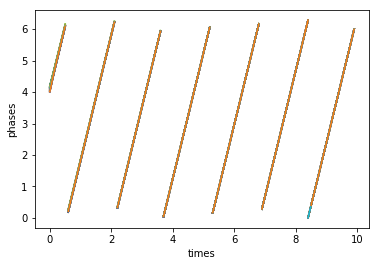

initial phases
[4.08828337 4.05672882 4.07470145 4.1227497  4.05581009 4.100233
 4.01146678 4.01607776 4.18580769 4.0689777  4.16749162 4.13063852
 4.1177196  4.05766823 4.13771763 4.15374204 4.05747485 4.15784927
 4.01585646 4.12503933 4.05447294 4.05046414 4.03636837 4.15581576
 4.03478516 4.10717578 4.1357763  4.05608679 4.15590425 4.17926463
 4.15590276 4.0899869  4.18545122 4.04298288 4.03720097 4.03175743
 4.13721385 4.11512268 4.08850233 4.15275901 4.16533625 4.1384094
 4.03728128 4.1825404  4.19477377 4.15286064 4.09446095 4.17030775
 4.1277105  4.18238668 4.02974397 4.09086414 4.19815577 4.07599135
 4.01620552 4.12703664 4.02384093 4.11207228 4.00768711 4.15669346
 4.00056925 4.02630654 4.06659657 4.04006121 4.00793983 4.15354242
 4.12416199 4.16447066 4.15102614 4.07836539 4.04216275 4.01316535]
final phases
[44.09634321 44.09621883 44.09409098 44.10160378 44.09504293 44.10044521
 44.09561655 44.097775   44.10210151 44.09864876 44.0962827  44.09710446
 44.09750694 44.10211743

In [34]:
import random

#These first few lines define an Erdos Renyi network with average degree
#2 and then it pulls out the largest connected component to analyze.
#(recall our results above are for connected graphs)

G = nx.fast_gnp_random_graph(100,2/99)#erdos-renyi, average degree 2
largest_component = max(nx.connected_components(G), key = len)
G = nx.Graph(nx.induced_subgraph(G,largest_component))
G = nx.convert_node_labels_to_integers(G)

initial_phase = {node:4+0.2*random.random() for node in G.nodes()}
natural_frequencies = {node:4 for node in G.nodes()}


times, X = solve_model(G, 10, c = 4, initial_phase = initial_phase, 
                       natural_frequencies = natural_frequencies, 
                       ntimes = 101) 
plot_phases(times, X)
plt.show()
print('initial phases')
print(X[0,:])
print('final phases')
print(X[-1,:])

Now we'll do the same calculations on the same network with the same initial phases, but we'll set the natural frequencies to be 0, corresponding to the change in variables to $\hat{\phi}$.  This will make the convergence clearer.  Note the changed vertical scale

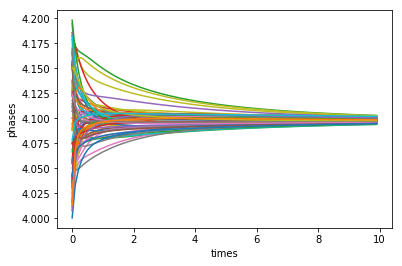

initial phases
[4.08828337 4.05672882 4.07470145 4.1227497  4.05581009 4.100233
 4.01146678 4.01607776 4.18580769 4.0689777  4.16749162 4.13063852
 4.1177196  4.05766823 4.13771763 4.15374204 4.05747485 4.15784927
 4.01585646 4.12503933 4.05447294 4.05046414 4.03636837 4.15581576
 4.03478516 4.10717578 4.1357763  4.05608679 4.15590425 4.17926463
 4.15590276 4.0899869  4.18545122 4.04298288 4.03720097 4.03175743
 4.13721385 4.11512268 4.08850233 4.15275901 4.16533625 4.1384094
 4.03728128 4.1825404  4.19477377 4.15286064 4.09446095 4.17030775
 4.1277105  4.18238668 4.02974397 4.09086414 4.19815577 4.07599135
 4.01620552 4.12703664 4.02384093 4.11207228 4.00768711 4.15669346
 4.00056925 4.02630654 4.06659657 4.04006121 4.00793983 4.15354242
 4.12416199 4.16447066 4.15102614 4.07836539 4.04216275 4.01316535]
final phases
[4.09634302 4.09621895 4.09409091 4.1016038  4.09504303 4.10044517
 4.09561636 4.09777505 4.10210172 4.09864874 4.0962828  4.09710454
 4.09750687 4.10211743 4.09771821 4.

In [35]:
natural_frequencies = {node:0 for node in G.nodes()}

#solve_model(G, tstop, c = 1, initial_phase = None, natural_frequencies = None, ntimes = 1001)
times, X = solve_model(G, 10, c = 4, initial_phase = initial_phase, 
                       natural_frequencies = natural_frequencies, 
                       ntimes = 101) 
plot_phases(times, X)
plt.show()
print('initial phases')
print(X[0,:])
print('final phases')
print(X[-1,:])


## Strongly-connected directed networks:

A directed network is strongly connected if it is possible to get from any one node to any other.

We could repeat the analysis we did above with a connected undirected network. The only place we used the fact that the network was undirected was in arguing that $c(A-D + d_MI)$ was *irreducible*.  It turns out that the same argument would work there if the original graph were simply strongly connected.  So the same analysis works.

